In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
#drop Total column and row in skim matrix
def drop_total(skim_matrix):
    skim_matrix=skim_matrix.drop(columns=["Total"])
    skim_matrix=skim_matrix.drop(index=["Total"])
    return skim_matrix

In [3]:
#convert AimSun indexes and column names to numerical format
def skim_matrix_col_index_fix(skim_matrix):
    skim_matrix.columns=list(map(lambda x: int(x), skim_matrix.columns))
    skim_matrix.index=list(map(lambda x: int(x), skim_matrix.index))
    return skim_matrix

In [4]:
#rename some columns in AimSun tables
def skim_matrix_renaming(skim_matrix):
    skim_matrix.columns=["origin_aimsun","destination_aimsun","travel_time_aimsun"]
    return skim_matrix

In [5]:
#dataframes to store number of trips and travel times for each iteration
travel_times_am=pd.DataFrame()
trips_number_am=pd.DataFrame()
travel_times_pm=pd.DataFrame()
trips_number_pm=pd.DataFrame()

In [6]:
#count number of unique O-D couples for number of trips
len_trips_number_am=[]
len_trips_number_pm=[]

cars_number_am=[]
cars_number_pm=[]

In [7]:
for skim_am_path, skim_pm_path, activity_schedule_path in zip(["skim_am/" + file for file in os.listdir("skim_am_new")],
                                                              ["skim_pm/" + file for file in os.listdir("skim_pm_new")],
                                                              ["activity_schedule/" + file for file in os.listdir("activity_schedule_new")]):
    #read files
    skim_am=pd.read_csv(skim_am_path,index_col=0)
    skim_pm=pd.read_csv(skim_pm_path,index_col=0)
    activity_schedule=pd.read_csv(activity_schedule_path, header=None, index_col=False, names=["person_id","tour_no","tour_type","stop_no","stop_type","stop_location",
                                                                   "stop_zone","stop_mode","primary_stop","arrival_time","departure_time",
                                                                   "prev_stop_location","prev_stop_zone","prev_stop_departure_time","pid"])
    
    #remove total columns and rows
    #skim_am=drop_total(skim_am)
    #skim_pm=drop_total(skim_pm)
    
    #fix indexes (some of them are in string format)
    skim_am=skim_matrix_col_index_fix(skim_am)
    skim_pm=skim_matrix_col_index_fix(skim_pm)
    
    #str values to float
    skim_am=skim_am.applymap(lambda x: str(x))
    skim_pm=skim_pm.applymap(lambda x: str(x))
    skim_am=skim_am.applymap(lambda x: x.replace(",","."))
    skim_pm=skim_pm.applymap(lambda x: x.replace(",","."))
    skim_am=skim_am.applymap(lambda x: float(x))
    skim_pm=skim_pm.applymap(lambda x: float(x))
    
    #skim matrixes to tables
    skim_am_table=skim_am.stack().reset_index()
    skim_pm_table=skim_pm.stack().reset_index()
    
    #rename skim matrix column names
    skim_am_table=skim_matrix_renaming(skim_am_table)
    skim_pm_table=skim_matrix_renaming(skim_pm_table)
    
    #delete O-D couples where origin and destination zones are the same
    skim_am_table=skim_am_table[skim_am_table["origin_aimsun"]!=skim_am_table["destination_aimsun"]]
    skim_pm_table=skim_pm_table[skim_pm_table["origin_aimsun"]!=skim_pm_table["destination_aimsun"]]
    
    #selection of am and pm time range and car transport mode
    activity_schedule_am=activity_schedule[(activity_schedule["arrival_time"]>=7.25) & (activity_schedule["arrival_time"]<=9.75)]
    activity_schedule_am=activity_schedule_am[(activity_schedule_am["stop_mode"]=="Car") | (activity_schedule_am["stop_mode"]=="Car Sharing 2") | (activity_schedule_am["stop_mode"]=="Car Sharing 3")]
    activity_schedule_pm=activity_schedule[(activity_schedule["arrival_time"]>=16.25) & (activity_schedule["arrival_time"]<=18.75)]
    activity_schedule_pm=activity_schedule_pm[(activity_schedule_pm["stop_mode"]=="Car") | (activity_schedule_pm["stop_mode"]=="Car Sharing 2") | (activity_schedule_pm["stop_mode"]=="Car Sharing 3")]
    
    #count number of trips for each zone couple
    activity_schedule_am["for_count"]=1
    activity_schedule_pm["for_count"]=1
    activity_schedule_am_count=activity_schedule_am.groupby(["prev_stop_zone","stop_zone"]).sum().reset_index()
    activity_schedule_pm_count=activity_schedule_pm.groupby(["prev_stop_zone","stop_zone"]).sum().reset_index()
    
    #count number of car trips
    cars_number_am.append(len(activity_schedule_am))
    cars_number_pm.append(len(activity_schedule_pm))
    
    #count number of unique O-D couples for number of trips
    len_trips_number_am.append(len(activity_schedule_am_count))
    len_trips_number_pm.append(len(activity_schedule_pm_count))
    
    #join skim matrix and table with number of trips received from activity schedule using O-D couples
    am_concated=pd.concat([skim_am_table.set_index(["origin_aimsun","destination_aimsun"]),activity_schedule_am_count.set_index(["prev_stop_zone","stop_zone"])],axis=1)
    pm_concated=pd.concat([skim_pm_table.set_index(["origin_aimsun","destination_aimsun"]),activity_schedule_pm_count.set_index(["prev_stop_zone","stop_zone"])],axis=1)
    
    #leave only columns with number of trips and travel time
    am_concated=am_concated[["travel_time_aimsun","for_count"]]
    pm_concated=pm_concated[["travel_time_aimsun","for_count"]]
    
    #rename "for_count" column
    am_concated=am_concated.rename(columns={"for_count":"trips_number"})
    pm_concated=pm_concated.rename(columns={"for_count":"trips_number"})
    
    #add trips number and travel time columns to correspondent dataframes
    travel_times_am=pd.concat([travel_times_am,am_concated["travel_time_aimsun"]],axis=1)
    trips_number_am=pd.concat([trips_number_am,am_concated["trips_number"]],axis=1)
    travel_times_pm=pd.concat([travel_times_pm,pm_concated["travel_time_aimsun"]],axis=1)
    trips_number_pm=pd.concat([trips_number_pm,pm_concated["trips_number"]],axis=1)

C:\Users\anash\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [8]:
len_trips_number_am

[31996, 19523, 31250, 19436, 30928, 27039, 26032, 26151]

In [9]:
np.array(len_trips_number_am)/33.33*100

array([95997.59975998, 58574.85748575, 93759.37593759, 58313.83138314,
       92793.27932793, 81125.11251125, 78103.81038104, 78460.84608461])

In [10]:
np.array(len_trips_number_pm)/33.33*100

array([85583.55835584, 52484.24842484, 85259.5259526 , 52580.2580258 ,
       84218.42184218, 72535.25352535, 70207.02070207, 70873.08730873])

In [11]:
39/33.3*100

117.11711711711712

In [12]:
#renaming columns, column name = iteration number
def column_rename(df):
    df.columns=list(range(1,df.shape[1]+1))
    return df

travel_times_am=column_rename(travel_times_am)
trips_number_am=column_rename(trips_number_am)
travel_times_pm=column_rename(travel_times_pm)
trips_number_pm=column_rename(trips_number_pm)

In [13]:
#number of unique O-D couples for trips table (am)
len_trips_number_am

[31996, 19523, 31250, 19436, 30928, 27039, 26032, 26151]

In [14]:
#number of unique O-D couples for trips table (pm)
len_trips_number_pm

[28525, 17493, 28417, 17525, 28070, 24176, 23400, 23622]

In [15]:
trips_number_am.isna().sum()

1    339834
2    352307
3    340580
4    352394
5    340902
6    344791
7    345798
8    345679
dtype: int64

In [16]:
travel_times_am.isna().sum()

1    949
2    949
3    949
4    949
5    949
6    949
7    949
8    949
dtype: int64

In [17]:
trips_number_am.sum()

1    46119.0
2    30437.0
3    46208.0
4    30258.0
5    46177.0
6    40208.0
7    39063.0
8    38981.0
dtype: float64

In [18]:
trips_number_pm.sum()

1    40214.0
2    29822.0
3    43066.0
4    29316.0
5    42785.0
6    37667.0
7    36823.0
8    36844.0
dtype: float64

In [19]:
trips_number_am=trips_number_am.fillna(0)
trips_number_pm=trips_number_pm.fillna(0)

In [20]:
trips_number_am.sum()

1    46119.0
2    30437.0
3    46208.0
4    30258.0
5    46177.0
6    40208.0
7    39063.0
8    38981.0
dtype: float64

In [21]:
(travel_times_am.iloc[:,1:]-travel_times_am.iloc[:,:-1]).sum()

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
dtype: float64

In [22]:
(trips_number_am.iloc[:,1:]-trips_number_am.iloc[:,:-1]).sum()

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
dtype: float64

In [23]:
(travel_times_am<0).sum()

1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

<h1>Thresholds</h1>

In [24]:
trips_number_am[1][trips_number_am[1]!=0]

1    32     1.0
     82     1.0
     100    1.0
     104    1.0
     121    1.0
           ... 
616  597    1.0
     604    2.0
     605    2.0
     606    1.0
     614    1.0
Name: 1, Length: 31996, dtype: float64

In [25]:
travel_times_am.loc[trips_number_am[1][trips_number_am[1]!=0].index]

1          2          3          4          5          6  \
1   32   31.892302  29.847010  30.050997  29.273993  30.036942  29.853125   
    82   52.239697  49.327126  47.750832  50.558739  48.239136  50.640602   
    100  48.796246  44.287716  44.027458  43.798222  44.071079  43.958466   
    104  50.553406  46.394909  46.693470  46.190716  47.203316  47.665272   
    121  54.070114  49.662903  49.643951  49.376656  49.508827  49.672138   
...            ...        ...        ...        ...        ...        ...   
616 597   7.280053   7.521269   7.648212   7.547673   7.688079   7.527492   
    604  48.503407  37.706074  46.077785  37.730690  46.112591  42.753326   
    605  16.237129  16.577980  14.008370  13.797208  14.484619  12.949862   
    606   8.989289   8.307513   8.290625   8.091747   8.174691   8.262609   
    614   5.679388   5.542232   5.642131   5.533803   5.638107   5.612114   

                 7          8  
1   32   29.483511  30.576982  
    82   46.895794  49.133331  
    100  44.029011  44.791904  
    104  45.911514  45.593361  
    121  49.676666  50.083561  
...            ...        ...  
616 597   7.593084   7.503430  
    604  42.530685  42.075687  
    605  14.071037  14.344401  
    606   8.362758   8.271191  
    614   5.599389   5.587121  

[31996 rows x 8 columns]

In [26]:
#multiplication of travel time columns representing each iteration by trips number for each iteration
def travel_times_trips_number_multipl(trips_number,travel_times):
    trips_number.columns=list(range(1,trips_number.shape[1]+1))
    travel_times.columns=list(range(1,travel_times.shape[1]+1))
    return trips_number*travel_times

In [27]:
am_multipl=travel_times_trips_number_multipl(trips_number_am,travel_times_am)
pm_multipl=travel_times_trips_number_multipl(trips_number_pm,travel_times_pm)

In [28]:
am_multipl.sum()

1    3.132015e+06
2    4.498628e+05
3    3.085171e+06
4    4.271834e+05
5    2.900338e+06
6    1.226600e+06
7    1.167796e+06
8    1.158935e+06
dtype: float64

In [29]:
pm_multipl.sum()

1    2.048491e+06
2    3.640966e+05
3    2.356222e+06
4    3.447943e+05
5    2.015383e+06
6    8.644649e+05
7    8.511455e+05
8    7.964099e+05
dtype: float64

In [30]:
#comparison of iterations #1-2 and iterations #2-3 (am)
pd.DataFrame(am_multipl.iloc[:,1:].values-am_multipl.iloc[:,:-1].values).sum()

0   -2.682153e+06
1    2.635308e+06
2   -2.657987e+06
3    2.473155e+06
4   -1.673738e+06
5   -5.880404e+04
6   -8.861117e+03
dtype: float64

In [31]:
#comparison of iterations #1-2 and iterations #2-3 (pm)
pd.DataFrame(pm_multipl.iloc[:,1:].values-pm_multipl.iloc[:,:-1].values).sum()

0   -1.684394e+06
1    1.992126e+06
2   -2.011428e+06
3    1.670588e+06
4   -1.150918e+06
5   -1.331947e+04
6   -5.473561e+04
dtype: float64

<h1>RMSN, RMSPE, U-statistic</h1>

In [32]:
def rmsn(multipl):
    return ((len(multipl)*pd.DataFrame(((multipl.iloc[:,1:].values-multipl.iloc[:,:-1].values)**2)).sum().values)**0.5)/multipl.iloc[:,:-1].sum().values

In [33]:
#rmsn calculation for dataframe with travel time multiplied by number of trips (am)
rmsn(am_multipl)

array([ 5.33624373, 38.04169556,  5.56034605, 37.60154444,  4.91443257,
        5.73692005,  6.40416838])

In [34]:
#rmsn calculation for dataframe with travel time multiplied by number of trips (pm)
rmsn(pm_multipl)

array([ 5.69580161, 42.42831992,  6.56114052, 36.7658576 ,  5.74193255,
        6.36654611,  6.79185428])

In [35]:
#rmsn for travel time (am)
rmsn(travel_times_am)

array([0.93919301, 1.9483782 , 0.90727563, 2.01101749, 0.7587148 ,
       0.54396572, 0.56029806])

In [36]:
#rmsn for travel time (pm)
rmsn(travel_times_pm)

array([0.72187642, 1.41705754, 0.78838527, 1.33587316, 0.66136213,
       0.43392393, 0.37573499])

In [37]:
#rmsn for number of trips (am)
rmsn(trips_number_am)

array([4.99828024, 5.94993262, 3.82476736, 5.84145115, 3.16934159,
       3.64400805, 3.85977717])

In [38]:
#rmsn for number of trips (pm)
rmsn(trips_number_pm)

array([7.02303127, 7.33194759, 4.86535957, 7.00181674, 3.90283802,
       4.55468433, 4.74862262])

In [39]:
def rmspe(multipl):
    return (1/len(multipl)*pd.DataFrame((((multipl.iloc[:,1:].values-multipl.iloc[:,:-1].values)/multipl.iloc[:,:-1].values)**2)).sum())**0.5

In [40]:
#replace 0 values by 0.00001
travel_times_am=travel_times_am.replace([0,0.00001])
travel_times_pm=travel_times_pm.replace([0,0.00001])

In [41]:
#rmspe for travel time (am)
rmspe(travel_times_am.dropna())

0    0.544297
1    2.949058
2    0.552520
3    2.847115
4    0.648233
5    0.725671
6    0.768875
dtype: float64

In [42]:
#rmspe for travel time (pm)
rmspe(travel_times_pm.dropna())

0    0.752182
1    2.619755
2    0.500714
3    2.416732
4    0.652117
5    0.556192
6    1.673186
dtype: float64

In [43]:
def mpe(multipl):
    return 1/len(multipl)*pd.DataFrame(((multipl.iloc[:,1:].values-multipl.iloc[:,:-1].values)/multipl.iloc[:,:-1].values)).sum()

In [44]:
#mpe for travel time (am)
mpe(travel_times_am.dropna())

0   -0.379678
1    1.504080
2   -0.333114
3    1.536970
4   -0.150882
5    0.067117
6    0.156042
dtype: float64

In [45]:
#mpe for travel time (am)
mpe(travel_times_pm.dropna())

0   -0.287989
1    1.294862
2   -0.341982
3    1.055664
4   -0.024025
5    0.037355
6    0.203566
dtype: float64

In [46]:
def u_statistic(multipl):
    return (1/len(multipl)*(pd.DataFrame(multipl.iloc[:,1:].values-multipl.iloc[:,:-1].values)**2).sum().values)**0.5/ \
    ((1/len(multipl)*pd.DataFrame((multipl.iloc[:,1:].values)**2).sum().values)**0.5+(1/len(multipl)*pd.DataFrame((multipl.iloc[:,:-1].values)**2).sum().values)**0.5)

In [47]:
u_statistic(am_multipl)

array([0.83504133, 0.83165587, 0.84833258, 0.8344712 , 0.62069879,
       0.53370289, 0.56539635])

In [48]:
u_statistic(pm_multipl)

array([0.79630807, 0.82531532, 0.84249217, 0.81059491, 0.64770332,
       0.52848178, 0.55848027])

In [49]:
def u_m(multipl):
    return (multipl.iloc[:,1:].mean().values-multipl.iloc[:,:-1].mean().values)**2/(1/len(multipl)*(pd.DataFrame(multipl.iloc[:,1:].values-multipl.iloc[:,:-1].values)**2).sum().values)

In [50]:
u_m(am_multipl)

array([2.58861549e-02, 2.38343006e-02, 2.41303410e-02, 2.38277081e-02,
       1.38596030e-02, 7.01892562e-05, 1.41103352e-06])

In [51]:
u_m(pm_multipl)

array([2.09324956e-02, 1.67032057e-02, 1.70031374e-02, 1.74437806e-02,
       9.93501724e-03, 5.88277770e-06, 9.00465068e-05])

In [52]:
def u_s(multipl):
    return (multipl.iloc[:,1:].std().values-multipl.iloc[:,:-1].std().values)**2/(1/len(multipl)*(pd.DataFrame(multipl.iloc[:,1:].values-multipl.iloc[:,:-1].values)**2).sum().values)

In [53]:
u_s(am_multipl)

array([0.67537302, 0.69984668, 0.73170305, 0.72934734, 0.50046038,
       0.00404446, 0.00273912])

In [54]:
u_s(pm_multipl)

array([0.50695161, 0.64241058, 0.68023408, 0.62939208, 0.46379664,
       0.00865931, 0.00953525])

In [55]:
def u_c(multipl):
    corr_vector=[]
    for i in range(1,multipl.shape[1]+1):
        for j in range(1,multipl.shape[1]+1):
            if i+1==j:
                corr_vector.append(multipl.corr().stack().loc[i,j])
    corr_vector=np.array(corr_vector)
    return 2*(1-corr_vector)*am_multipl.iloc[:,1:].std().values*multipl.iloc[:,:-1].std().values/(1/len(multipl)*(pd.DataFrame(multipl.iloc[:,1:].values-multipl.iloc[:,:-1].values)**2).sum().values)

In [56]:
u_c(am_multipl)

array([0.30130223, 0.27888043, 0.24672802, 0.24938637, 0.48824146,
       0.99844683, 0.99982094])

In [57]:
u_c(pm_multipl)

array([0.46055749, 0.38393978, 0.2962144 , 0.45497965, 0.67770614,
       1.23555162, 1.29817532])

In [58]:
#u_c values are a bit weird (mainly for pm data)

<h1>Descriptive statistics</h1>

In [59]:
am_multipl.describe().to_excel(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Meeting 04.07\am_descriptive_stats.xlsx")

In [60]:
am_multipl.describe()

,1,2,3,4,5,6,7,8
count,370881.000000,370881.000000,370881.000000,370881.000000,370881.000000,370881.000000,370881.000000,370881.000000
mean,8.444799,1.212957,8.318492,1.151807,7.820131,3.307260,3.148707,3.124815
std,44.979528,8.040372,46.543587,7.079323,43.972222,16.853923,18.057482,17.004816
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3065.013626,1093.384272,3075.086288,913.518347,3231.865166,1463.423962,1363.297050,1676.387650


In [61]:
mean_am=[]
std_am=[]
for i in range(am_multipl.shape[1]):
    mean_am.append(am_multipl[am_multipl.iloc[:,i]!=0].iloc[:,i].mean())
    std_am.append(am_multipl[am_multipl.iloc[:,i]!=0].iloc[:,i].std())

In [62]:
(travel_times_am==0).sum()

1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [63]:
for mean, std, iteration in zip(mean_am,std_am,list(range(am_multipl.shape[1]))):
    print("iteration "+str(iteration+1)+":\t",mean,"(mean)\t",std,"(std)\t")

iteration 1:	 100.1155663686855 (mean)	 121.68758602105088 (std)	
iteration 2:	 23.149427767858537 (mean)	 26.94482413644075 (std)	
iteration 3:	 98.95344777035433 (mean)	 129.61994790150126 (std)	
iteration 4:	 22.1063626968612 (mean)	 22.331021716703063 (std)	
iteration 5:	 94.02334542376228 (mean)	 123.05662207579488 (std)	
iteration 6:	 45.505464047042054 (mean)	 44.589222619145374 (std)	
iteration 7:	 45.027790398121525 (mean)	 52.700502662763505 (std)	
iteration 8:	 44.451312800132634 (mean)	 47.71256713917478 (std)	


In [64]:
pm_multipl.describe().to_excel(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Meeting 04.07\pm_descriptive_stats.xlsx")

In [65]:
pm_multipl.describe()

,1,2,3,4,5,6,7,8
count,370881.000000,370881.000000,370881.000000,370881.000000,370881.000000,370881.000000,370881.000000,370881.000000
mean,5.523310,0.981707,6.353041,0.929663,5.434041,2.330842,2.294929,2.147346
std,30.630887,8.280661,41.591731,7.288535,34.345258,13.142655,14.520508,13.001822
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1955.158386,1034.873852,4809.526825,838.636139,2777.747070,1217.481510,1561.120964,1134.224701


In [66]:
pm_multipl.std()

1    30.630887
2     8.280661
3    41.591731
4     7.288535
5    34.345258
6    13.142655
7    14.520508
8    13.001822
dtype: float64

In [67]:
mean_pm=[]
std_pm=[]
for i in range(pm_multipl.shape[1]):
    mean_pm.append(pm_multipl[pm_multipl.iloc[:,i]!=0].iloc[:,i].mean())
    std_pm.append(pm_multipl[pm_multipl.iloc[:,i]!=0].iloc[:,i].std())
for mean, std, iteration in zip(mean_pm,std_pm,list(range(pm_multipl.shape[1]))):
    print("iteration "+str(iteration+1)+":\t",mean,"(mean)\t",std,"(std)\t")

iteration 1:	 73.28340010311132 (mean)	 86.50596230417996 (std)	
iteration 2:	 20.93832961338564 (mean)	 32.32147698792289 (std)	
iteration 3:	 83.07966465790876 (mean)	 127.46718733174049 (std)	
iteration 4:	 19.774850881007062 (mean)	 27.520049460872865 (std)	
iteration 5:	 72.01138551266847 (mean)	 104.10532973052557 (std)	
iteration 6:	 35.87140262336166 (mean)	 38.14699041366811 (std)	
iteration 7:	 36.51261055916721 (mean)	 45.883307050380175 (std)	
iteration 8:	 33.84801126243335 (mean)	 39.89614263236173 (std)	


<h1>Distribution plots</h1>

In [68]:
#when we divided number of trips by 3
#trips_number_am_plot=trips_number_am
#trips_number_pm_plot=trips_number_pm
#trips_number_am_plot.columns=list(range(1,4))
#trips_number_pm_plot.columns=list(range(1,4))
#trips_number_am_plot[1]=trips_number_am.loc[:,1]/3
#trips_number_pm_plot[1]=trips_number_pm.loc[:,1]/3
#am_multipl_plot=travel_times_trips_number_multipl(trips_number_am,travel_times_am)
#pm_multipl_plot=travel_times_trips_number_multipl(trips_number_pm,travel_times_pm)

In [69]:
#NOW WE DON'T DIVIDE BY 3
am_multipl_plot=am_multipl
pm_multipl_plot=pm_multipl

In [70]:
import scipy
def area_under_curve(multipl,i):
    i=i-1
    x,y=sns.kdeplot(multipl[multipl.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35).get_lines()[0].get_data()
    return scipy.integrate.simps(x=x,y=y)

In [71]:
#qgis plot
qgis_tt_am=pd.read_csv("amcosts_qgis_PTcostzero.csv")
qgis_tt_pm=pd.read_csv("pmcosts_qgis_PTcostzero.csv")
qgis_tt_am=pd.DataFrame(qgis_tt_am.set_index(["origin_zone","destination_zone"])["car_ivt"])
qgis_tt_pm=pd.DataFrame(qgis_tt_pm.set_index(["origin_zone","destination_zone"])["car_ivt"])
qgis_tt_am=qgis_tt_am.reset_index()
qgis_tt_pm=qgis_tt_pm.reset_index()

In [72]:
trips_number_qgis_am=pd.DataFrame(trips_number_am[1]).reset_index()
trips_number_qgis_pm=pd.DataFrame(trips_number_pm[1]).reset_index()
qgis_am=qgis_tt_am.merge(trips_number_qgis_am,left_on=["origin_zone","destination_zone"],right_on=["level_0","level_1"],how="left").set_index(["origin_zone","destination_zone"]).drop(columns=["level_0","level_1"])
qgis_pm=qgis_tt_pm.merge(trips_number_qgis_pm,left_on=["origin_zone","destination_zone"],right_on=["level_0","level_1"],how="left").set_index(["origin_zone","destination_zone"]).drop(columns=["level_0","level_1"])
qgis_am=qgis_am.fillna(0)
qgis_pm=qgis_pm.fillna(0)
qgis_am["multipl"]=qgis_am["car_ivt"]*qgis_am[1]*60
qgis_pm["multipl"]=qgis_pm["car_ivt"]*qgis_pm[1]*60

In [73]:
qgis_am[qgis_am[1]!=0]["car_ivt"]*60

origin_zone  destination_zone
1            32                   7.708518
             82                   9.733950
             100                  9.479099
             104                 10.933482
             121                 10.369251
                                   ...    
616          597                  5.221121
             604                  7.110790
             605                  6.098095
             606                  3.050891
             614                  0.906831
Name: car_ivt, Length: 31947, dtype: float64

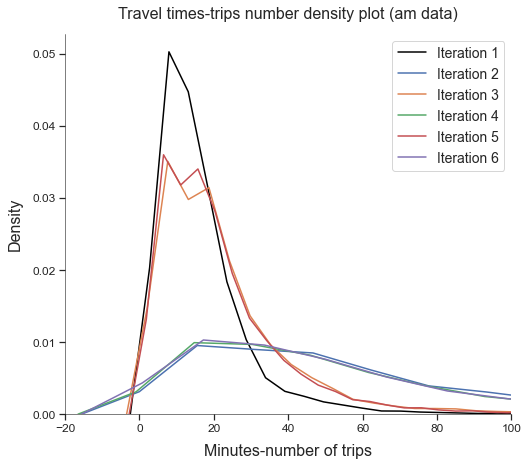

In [92]:
#plot with the first column devided by 3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.facecolor':'white', 'figure.facecolor':'white','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
sns.color_palette("Set3", 10)
sns.kdeplot(qgis_am[qgis_am[1]!=0]["multipl"],bw_adjust=0.35,linewidth=1.5,label="Iteration 1",color="black")
for i,color in zip(range(am_multipl_plot.shape[1]),sns.color_palette().as_hex()[0:am_multipl_plot.shape[1]]):
    if i<=4:
        sns.kdeplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="Iteration "+str(i+2),color=color)
        #sns.histplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(am_multipl_plot.iloc[:,i].max()/10), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
    #else:
        #sns.kdeplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="quantile = 0.32, "+"iteration "+str(i+2),color=color)
        #sns.histplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(am_multipl_plot.iloc[:,i].max()/10), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
plt.xlim(-20,100)
plt.legend(fontsize=14)
plt.xlabel("Minutes-number of trips",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.xticks(visible=True,fontsize=12)
plt.yticks(visible=True,fontsize=12)
plt.title("Travel times-trips number density plot (am data)",fontsize=16,pad=15)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\IEEE_paper\figure5_1.svg")

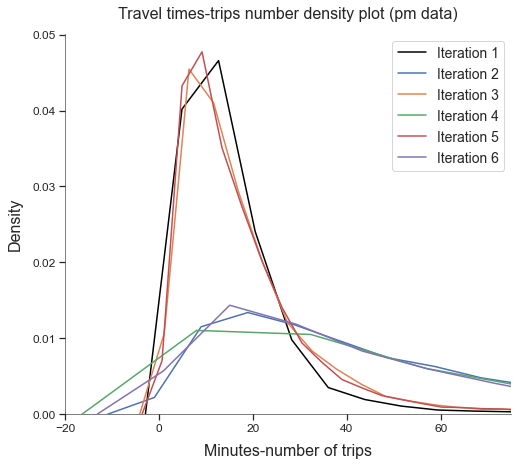

In [93]:
#plot with the first column devided by 3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.facecolor':'white', 'figure.facecolor':'white','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
sns.kdeplot(qgis_pm[qgis_pm[1]!=0]["multipl"],bw_adjust=0.35,linewidth=1.5,label="Iteration 1",color="black")
for i,color in zip(range(pm_multipl_plot.shape[1]),sns.color_palette().as_hex()[0:pm_multipl_plot.shape[1]]):
    if i<=4:
        #sns.histplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(pm_multipl_plot.iloc[:,i].max()/3.5), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
        sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="Iteration "+str(i+2),color=color)
    #else:
        #sns.histplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(pm_multipl_plot.iloc[:,i].max()/3.5), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
        #sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1,label="quantile = 0.32, "+"Iteration "+str(i+2),color=color)
plt.xlim(-20,75)
plt.legend(fontsize=14)
plt.xlabel("Minutes-number of trips",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Travel times-trips number density plot (pm data)",fontsize=16,pad=15)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\IEEE_paper\figure5_2.svg")

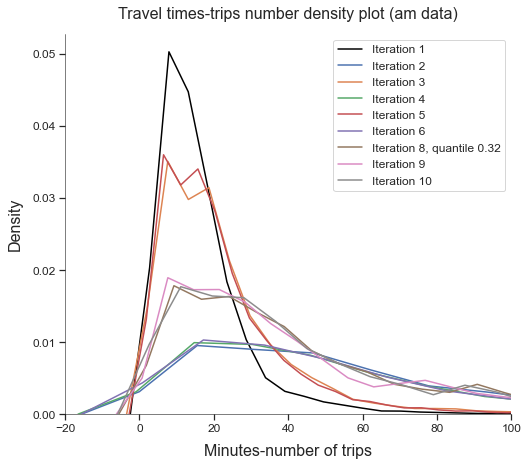

In [100]:
#plot with the first column devided by 3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.facecolor':'white', 'figure.facecolor':'white','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
sns.color_palette("Set3", 10)
sns.kdeplot(qgis_am[qgis_am[1]!=0]["multipl"],bw_adjust=0.35,linewidth=1.5,label="Iteration 1",color="black")
for i,color in zip(range(am_multipl_plot.shape[1]),sns.color_palette().as_hex()[0:am_multipl_plot.shape[1]]):
    if i<=4:
        sns.kdeplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="Iteration "+str(i+2),color=color)
        #sns.histplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(am_multipl_plot.iloc[:,i].max()/10), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
    else:
        if i==5:
            sns.kdeplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="Iteration "+str(i+3)+", quantile 0.32",color=color)
        else:
            sns.kdeplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="Iteration "+str(i+3),color=color)
        #sns.histplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(am_multipl_plot.iloc[:,i].max()/10), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
plt.xlim(-20,100)
plt.legend(fontsize=12)
plt.xlabel("Minutes-number of trips",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.xticks(visible=True,fontsize=12)
plt.yticks(visible=True,fontsize=12)
plt.title("Travel times-trips number density plot (am data)",fontsize=16,pad=15)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\IEEE_paper\figure7_1.svg")

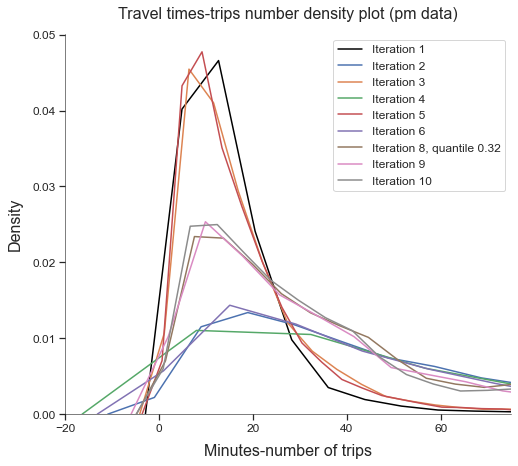

In [101]:
#plot with the first column devided by 3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.facecolor':'white', 'figure.facecolor':'white','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
sns.kdeplot(qgis_pm[qgis_pm[1]!=0]["multipl"],bw_adjust=0.35,linewidth=1.5,label="Iteration 1",color="black")
for i,color in zip(range(pm_multipl_plot.shape[1]),sns.color_palette().as_hex()[0:pm_multipl_plot.shape[1]]):
    if i<=4:
        #sns.histplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(pm_multipl_plot.iloc[:,i].max()/3.5), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
        sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="Iteration "+str(i+2),color=color)
    else:
        #sns.histplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(pm_multipl_plot.iloc[:,i].max()/3.5), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
        if i==5:
            sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="Iteration "+str(i+3)+", quantile 0.32",color=color)
        else:
            sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="Iteration "+str(i+3),color=color)
plt.xlim(-20,75)
plt.legend(fontsize=12)
plt.xlabel("Minutes-number of trips",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Travel times-trips number density plot (pm data)",fontsize=16,pad=15)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\IEEE_paper\figure7_2.svg")

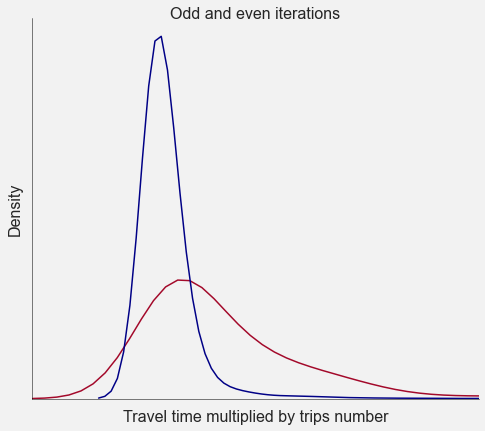

In [76]:
#plot with the first column devided by 3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.facecolor':'#F2F2F2', 'figure.facecolor':'#F2F2F2','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,0]!=0].iloc[:,0],bw_adjust=3,linewidth=1.5,label="Even iterations",color="#A3092A")
sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,1]!=0].iloc[:,1],bw_adjust=3,linewidth=1.5,label="Odd iterations",color="#000086")
plt.xlim(-100,300)
plt.tick_params(
    axis='both', 
    which='both',   
    bottom=False,      
    top=False,        
    labelbottom=False,
    left=False,
    right=False,
    labelleft=False)
#plt.legend(fontsize=14)
plt.xlabel("Travel time multiplied by trips number",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.title("Odd and even iterations",fontsize=16,pad=0)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Poster\Plots\odd_even_iterations_filled_areas.svg")

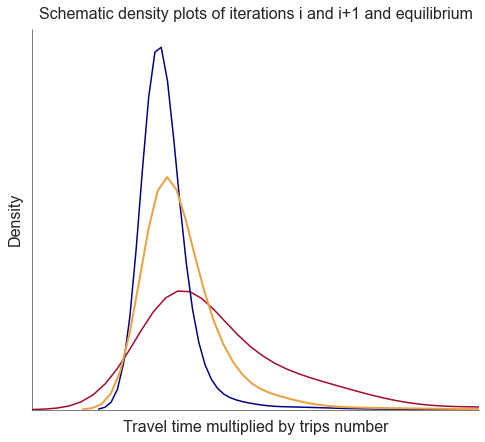

In [79]:
#plot with the first column devided by 3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,0]!=0].iloc[:,0],bw_adjust=3,linewidth=1.5,label="Even iterations",color="#A3092A")
sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,1]!=0].iloc[:,1],bw_adjust=3,linewidth=1.5,label="Odd iterations",color="#000086")
sns.kdeplot(pm_multipl_plot[pm_multipl_plot.iloc[:,6]!=0].iloc[:,6],bw_adjust=3,linewidth=2,label="Quantile",color="#EAA242")
plt.xlim(-100,300)
plt.tick_params(
    axis='both', 
    which='both',   
    bottom=False,      
    top=False,        
    labelbottom=False,
    left=False,
    right=False,
    labelleft=False)
#plt.legend(fontsize=14)
plt.xlabel("Travel time multiplied by trips number",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.title("Schematic density plots of iterations i and i+1 and equilibrium",fontsize=16,pad=10)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\IEEE_paper\odd_even_iterations.svg")

In [78]:
am_multipl_plot.mean()

1    8.444799
2    1.212957
3    8.318492
4    1.151807
5    7.820131
6    3.307260
7    3.148707
8    3.124815
dtype: float64

In [79]:
am_multipl_plot.std()

1    44.979528
2     8.040372
3    46.543587
4     7.079323
5    43.972222
6    16.853923
7    18.057482
8    17.004816
dtype: float64

In [80]:
pm_multipl_plot.mean()

1    5.523310
2    0.981707
3    6.353041
4    0.929663
5    5.434041
6    2.330842
7    2.294929
8    2.147346
dtype: float64

In [81]:
pm_multipl_plot.std()

1    30.630887
2     8.280661
3    41.591731
4     7.288535
5    34.345258
6    13.142655
7    14.520508
8    13.001822
dtype: float64

1.0026269555092382

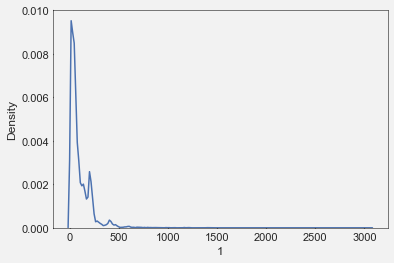

In [82]:
#iteration 1 am
it1_area_am=area_under_curve(am_multipl_plot,1)
it1_area_am

1.0088560476770194

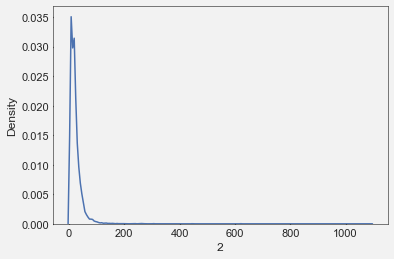

In [83]:
#iteration 2 am
it2_area_am=area_under_curve(am_multipl_plot,2)
it2_area_am

1.0017009342564362

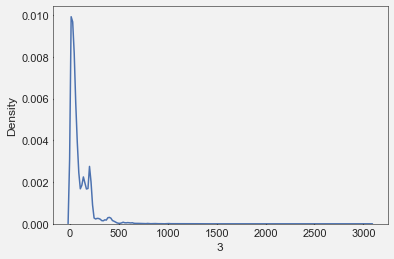

In [84]:
#iteration 3 am
it3_area_am=area_under_curve(am_multipl_plot,3)
it3_area_am

1.0088783562129844

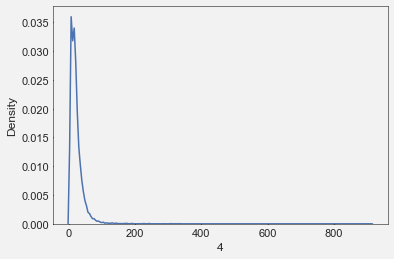

In [85]:
#iteration 4 am
it4_area_am=area_under_curve(am_multipl_plot,4)
it4_area_am

In [86]:
print("iteration 2 - iteration 1 (am):",it2_area_am-it1_area_am)

iteration 2 - iteration 1 (am): 0.006229092167781225


In [87]:
print("iteration 3 - iteration 2 (am):",it3_area_am-it2_area_am)

iteration 3 - iteration 2 (am): -0.00715511342058317


In [88]:
print("iteration 4 - iteration 3 (am):",it4_area_am-it3_area_am)

iteration 4 - iteration 3 (am): 0.007177421956548136


1.0011913314317427

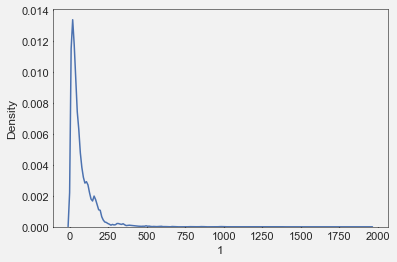

In [89]:
#iteration 1 pm
it1_area_pm=area_under_curve(pm_multipl_plot,1)
it1_area_pm

0.9989585697202303

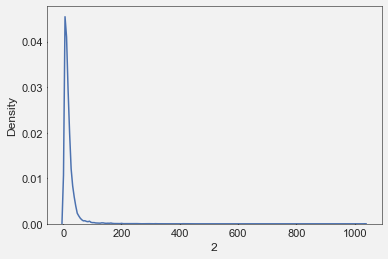

In [90]:
#iteration 2 pm
it2_area_pm=area_under_curve(pm_multipl_plot,2)
it2_area_pm

1.047519665096942

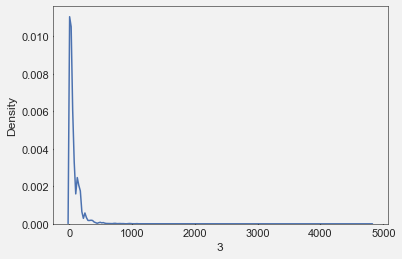

In [91]:
#iteration 3 pm
it3_area_pm=area_under_curve(pm_multipl_plot,3)
it3_area_pm

0.9985429624879183

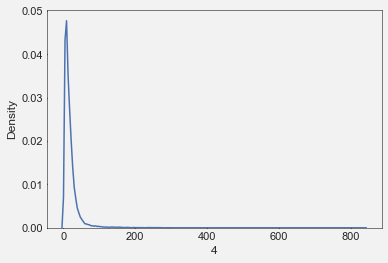

In [92]:
#iteration 4 pm
it4_area_pm=area_under_curve(pm_multipl_plot,4)
it4_area_pm

In [93]:
print("iteration 2 - iteration 1 (pm):",it2_area_pm-it1_area_pm)

iteration 2 - iteration 1 (pm): -0.002232761711512321


In [94]:
print("iteration 3 - iteration 2 (pm):",it3_area_pm-it2_area_pm)

iteration 3 - iteration 2 (pm): 0.048561095376711716


In [95]:
print("iteration 4 - iteration 3 (pm):",it4_area_pm-it3_area_pm)

iteration 4 - iteration 3 (pm): -0.04897670260902376


In [96]:
#travel times density plots

In [97]:
trips_number_am

1    2    3    4    5    6    7    8
1   2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
    4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    5    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    6    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...      ...  ...  ...  ...  ...  ...  ...  ...
616 611  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    612  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
    613  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    614  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
    615  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[371830 rows x 8 columns]

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

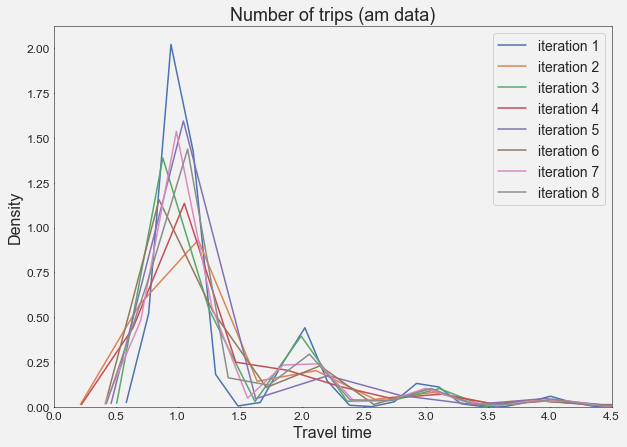

In [98]:
plt.figure(figsize=(10, 7))
sns.color_palette("Set3", 10)
for i,color in zip(range(travel_times_am.shape[1]),sns.color_palette().as_hex()[0:am_multipl_plot.shape[1]]):
    sns.kdeplot(trips_number_am.iloc[:,i].drop(index=trips_number_am[trips_number_am.iloc[:,i]==0].index),label="iteration "+str(i+1),color=color)
plt.xlim(0,4.5)
plt.legend(fontsize=14)
plt.title("Number of trips (am data)",fontsize=18)
plt.xlabel("Travel time",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

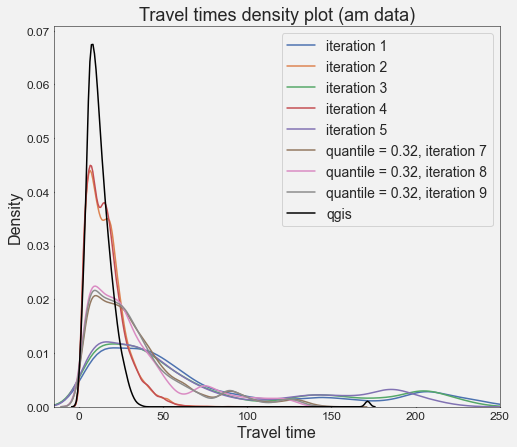

In [99]:
plt.figure(figsize=(8, 7))
sns.color_palette("Set3", 10)
for i,color in zip(range(travel_times_am.shape[1]),sns.color_palette().as_hex()[0:am_multipl_plot.shape[1]]):
    if i<=4:
        sns.kdeplot(travel_times_am.iloc[:,i].drop(index=trips_number_am[trips_number_am.iloc[:,i]==0].index),label="iteration "+str(i+1),color=color)
    else:
        sns.kdeplot(travel_times_am.iloc[:,i].drop(index=trips_number_am[trips_number_am.iloc[:,i]==0].index),label="quantile = 0.32, iteration "+str(i+2),color=color)
sns.kdeplot(qgis_am[qgis_am[1]!=0]["car_ivt"]*60,label="qgis",color="black")
plt.xlim(-15,250)
plt.legend(fontsize=14)
plt.title("Travel times density plot (am data)",fontsize=18)
plt.xlabel("Travel time",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Presentation 04.08\travel_times_density_am.svg")

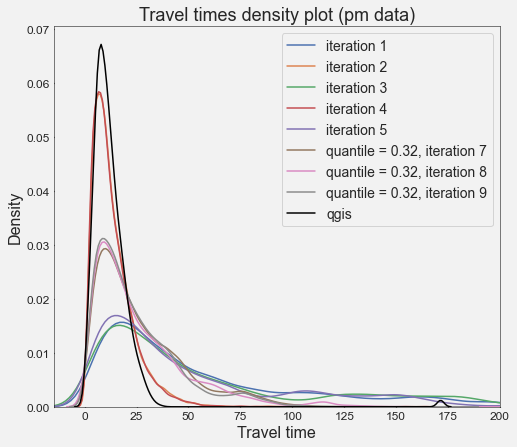

In [100]:
plt.figure(figsize=(8, 7))
sns.color_palette("Set3", 10)
for i,color in zip(range(travel_times_pm.shape[1]),sns.color_palette().as_hex()[0:pm_multipl_plot.shape[1]]):
    if i<=4:
        sns.kdeplot(travel_times_pm.iloc[:,i].drop(index=trips_number_pm[trips_number_pm.iloc[:,i]==0].index),label="iteration "+str(i+1),color=color)
    else:
        sns.kdeplot(travel_times_pm.iloc[:,i].drop(index=trips_number_pm[trips_number_pm.iloc[:,i]==0].index),label="quantile = 0.32, iteration "+str(i+2),color=color)
sns.kdeplot(qgis_pm[qgis_pm[1]!=0]["car_ivt"]*60,label="qgis",color="black")
plt.xlim(-15,200)
plt.legend(fontsize=14)
plt.title("Travel times density plot (pm data)",fontsize=18)
plt.xlabel("Travel time",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Presentation 04.08\travel_times_density_pm.svg")

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

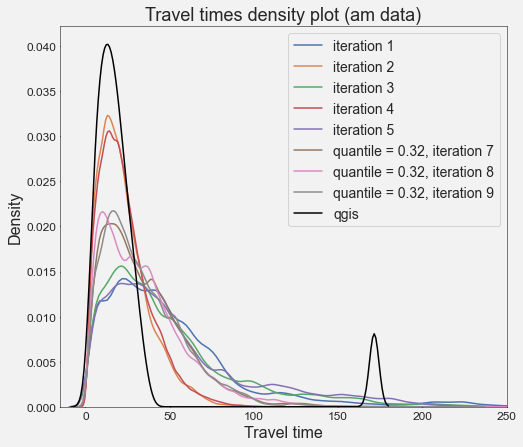

In [101]:
plt.figure(figsize=(8, 7))
sns.color_palette("Set3", 10)
for i,color in zip(range(travel_times_am.shape[1]),sns.color_palette().as_hex()[0:am_multipl_plot.shape[1]]):
    if i<=4:
        sns.kdeplot(travel_times_am.iloc[:,i],label="iteration "+str(i+1),color=color)
    else:
        sns.kdeplot(travel_times_am.iloc[:,i],label="quantile = 0.32, iteration "+str(i+2),color=color)
sns.kdeplot(qgis_am["car_ivt"]*60,label="qgis",color="black")
plt.xlim(-15,250)
plt.legend(fontsize=14)
plt.title("Travel times density plot (am data)",fontsize=18)
plt.xlabel("Travel time",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

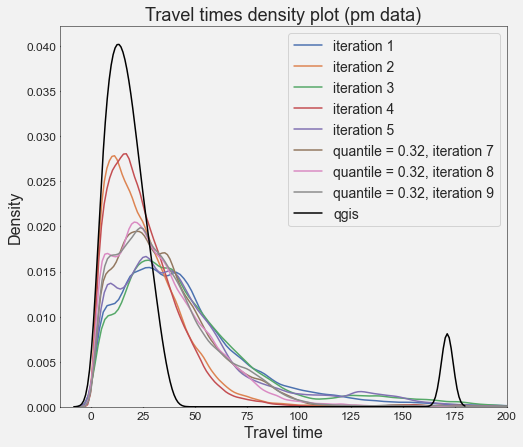

In [102]:
plt.figure(figsize=(8, 7))
sns.color_palette("Set3", 10)
for i,color in zip(range(travel_times_pm.shape[1]),sns.color_palette().as_hex()[0:pm_multipl_plot.shape[1]]):
    if i<=4:
        sns.kdeplot(travel_times_pm.iloc[:,i],label="iteration "+str(i+1),color=color)
    else:
        sns.kdeplot(travel_times_pm.iloc[:,i],label="quantile = 0.32, iteration "+str(i+2),color=color)
sns.kdeplot(qgis_pm["car_ivt"]*60,label="qgis",color="black")
plt.xlim(-15,200)
plt.legend(fontsize=14)
plt.title("Travel times density plot (pm data)",fontsize=18)
plt.xlabel("Travel time",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [103]:
travel_times_am=travel_times_am.iloc[:,:5]
travel_times_pm=travel_times_pm.iloc[:,:5]

In [104]:
#rows only with nans
skim_mean_am=travel_times_am.mean(axis=1).unstack()
skim_mean_am

,1,2,3,4,5,6,7,8,9,10,...,607,608,609,610,611,612,613,614,615,616
1,NaN,9.442971,6.372201,4.785124,30.133521,32.898009,27.861498,16.618373,11.537925,9.314794,...,66.147273,96.875157,71.911964,66.750590,72.593543,64.144408,70.213897,68.167143,65.858070,71.567851
2,10.892798,NaN,5.048769,6.921601,27.132387,29.896877,24.860364,13.617241,8.536793,6.313662,...,63.146146,66.782932,68.910835,63.749465,69.592412,61.143282,67.212772,65.166018,62.856944,68.566726
3,7.718787,5.029258,NaN,3.747590,24.218882,26.983372,21.946859,10.703737,5.623288,4.084139,...,60.355376,63.992162,66.120065,60.958700,66.801645,58.352515,64.422006,62.375253,60.066177,65.775961
4,5.990766,6.677417,3.606646,NaN,27.367965,30.132455,25.095942,13.852819,8.772371,6.418826,...,63.246394,66.883179,69.011081,63.849712,69.692661,61.243530,67.313020,65.266266,62.957192,68.666974
5,32.096552,27.645592,24.751599,28.125355,NaN,4.522196,5.277028,18.006595,21.028784,25.698549,...,53.782797,57.419580,59.547485,54.386117,60.229063,51.779932,57.849424,55.802670,53.493593,59.203379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,88.421037,83.970084,81.081463,84.436013,80.181242,82.945735,77.909222,80.270249,83.292442,72.564310,...,4.703080,5.331566,7.459471,3.423176,42.149297,NaN,6.886483,4.839730,2.530652,8.240437
613,92.339455,87.888502,84.999880,88.354431,84.099656,86.864146,81.827636,84.188666,87.210860,76.482728,...,8.621494,9.076326,11.204230,4.890869,46.067712,4.355142,NaN,3.254655,4.928963,3.625049
614,94.488708,90.037755,87.149133,90.503683,86.248911,89.013402,83.976891,86.337923,89.360117,78.631984,...,10.770749,11.225581,13.353485,2.720021,48.216968,6.504398,4.420350,NaN,2.758116,5.774304
615,90.364031,85.913078,83.024457,86.379008,82.124240,84.888728,79.852220,82.213248,85.235439,74.507308,...,6.646076,7.100907,9.228811,4.313891,44.092295,2.379724,3.375187,5.595041,NaN,1.991722


In [105]:
#columns
columns_drop=travel_times_am.mean(axis=1).unstack().isna().sum(axis=0)[travel_times_am.mean(axis=1).unstack().isna().sum(axis=0)>8].index
columns_drop

Int64Index([132, 227, 248, 249, 371, 452], dtype='int64')

In [106]:
#rows
index_drop=travel_times_am.mean(axis=1).unstack().isna().sum(axis=1)[travel_times_am.mean(axis=1).unstack().isna().sum(axis=1)>8].index
index_drop

Int64Index([98, 132, 227, 248, 249, 371, 452], dtype='int64')

In [107]:
skim_mean_am=skim_mean_am.drop(index=index_drop).drop(columns=columns_drop).fillna(0)

In [108]:
skim_mean_am.to_csv("skim_am_mean.csv")

In [109]:
#rows only with nans
skim_mean_pm=travel_times_pm.mean(axis=1).unstack()
skim_mean_pm

,1,2,3,4,5,6,7,8,9,10,...,607,608,609,610,611,612,613,614,615,616
1,NaN,9.799007,7.006542,9.234631,30.137007,32.744755,28.067952,17.298766,11.993341,9.742396,...,73.328178,75.552632,77.326865,73.500530,77.794664,71.112596,77.076492,74.850904,72.810552,78.584998
2,25.588844,NaN,5.100596,26.510112,26.813494,29.421242,24.744439,13.975252,8.669827,6.418881,...,70.004668,72.229121,74.003354,70.177020,74.471152,67.789085,73.752981,71.527393,69.487041,75.261487
3,14.131654,6.516774,NaN,14.402536,23.792644,26.400392,21.723589,10.961069,5.648976,6.473958,...,66.859129,69.083583,70.857816,67.031481,71.325615,64.643547,70.607442,68.381855,66.341503,72.115948
4,5.348369,6.914389,4.121924,NaN,27.252390,29.860138,25.183335,14.414148,9.108723,6.873934,...,70.482642,72.707095,74.481328,70.654994,74.949127,68.267060,74.230956,72.005368,69.965016,75.739462
5,115.822383,96.709035,89.444571,116.743658,NaN,4.383708,5.452881,53.309029,60.058648,42.695271,...,63.508677,65.733129,67.507362,63.681030,67.975156,61.293096,67.256992,65.031404,62.991052,68.765498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,157.368649,138.255289,130.990813,158.289917,65.483455,68.091207,63.414406,93.627856,101.780544,64.281152,...,4.665436,4.611194,6.385425,3.224642,37.392255,NaN,6.800603,4.575016,2.534661,8.309110
613,161.712964,142.599609,135.335130,162.634235,69.827780,72.435533,67.758729,97.972177,106.124867,68.625469,...,9.009757,8.602338,10.376569,4.779163,41.736575,4.593299,NaN,3.159233,4.970294,3.795591
614,163.966119,144.852765,137.588286,164.887390,72.080934,74.688686,70.011883,100.225333,108.378024,70.878624,...,11.262910,10.855491,12.629722,2.705293,43.989726,6.846453,4.540238,NaN,2.896425,6.048745
615,159.519901,140.406546,133.142070,160.441168,67.634718,70.242471,80.420725,95.779115,103.931805,66.432413,...,6.816697,6.409278,8.183509,4.113098,39.543516,2.400239,3.289497,5.393179,NaN,1.944966


In [110]:
#columns
columns_drop=travel_times_pm.mean(axis=1).unstack().isna().sum(axis=0)[travel_times_pm.mean(axis=1).unstack().isna().sum(axis=0)>8].index
columns_drop

Int64Index([132, 227, 248, 249, 371, 452], dtype='int64')

In [111]:
#rows
index_drop=travel_times_pm.mean(axis=1).unstack().isna().sum(axis=1)[travel_times_pm.mean(axis=1).unstack().isna().sum(axis=1)>8].index
index_drop

Int64Index([98, 132, 227, 248, 249, 371, 452], dtype='int64')

In [112]:
skim_mean_pm=skim_mean_pm.drop(index=index_drop).drop(columns=columns_drop).fillna(0)

In [113]:
skim_mean_pm

,1,2,3,4,5,6,7,8,9,10,...,607,608,609,610,611,612,613,614,615,616
1,0.000000,9.799007,7.006542,9.234631,30.137007,32.744755,28.067952,17.298766,11.993341,9.742396,...,73.328178,75.552632,77.326865,73.500530,77.794664,71.112596,77.076492,74.850904,72.810552,78.584998
2,25.588844,0.000000,5.100596,26.510112,26.813494,29.421242,24.744439,13.975252,8.669827,6.418881,...,70.004668,72.229121,74.003354,70.177020,74.471152,67.789085,73.752981,71.527393,69.487041,75.261487
3,14.131654,6.516774,0.000000,14.402536,23.792644,26.400392,21.723589,10.961069,5.648976,6.473958,...,66.859129,69.083583,70.857816,67.031481,71.325615,64.643547,70.607442,68.381855,66.341503,72.115948
4,5.348369,6.914389,4.121924,0.000000,27.252390,29.860138,25.183335,14.414148,9.108723,6.873934,...,70.482642,72.707095,74.481328,70.654994,74.949127,68.267060,74.230956,72.005368,69.965016,75.739462
5,115.822383,96.709035,89.444571,116.743658,0.000000,4.383708,5.452881,53.309029,60.058648,42.695271,...,63.508677,65.733129,67.507362,63.681030,67.975156,61.293096,67.256992,65.031404,62.991052,68.765498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,157.368649,138.255289,130.990813,158.289917,65.483455,68.091207,63.414406,93.627856,101.780544,64.281152,...,4.665436,4.611194,6.385425,3.224642,37.392255,0.000000,6.800603,4.575016,2.534661,8.309110
613,161.712964,142.599609,135.335130,162.634235,69.827780,72.435533,67.758729,97.972177,106.124867,68.625469,...,9.009757,8.602338,10.376569,4.779163,41.736575,4.593299,0.000000,3.159233,4.970294,3.795591
614,163.966119,144.852765,137.588286,164.887390,72.080934,74.688686,70.011883,100.225333,108.378024,70.878624,...,11.262910,10.855491,12.629722,2.705293,43.989726,6.846453,4.540238,0.000000,2.896425,6.048745
615,159.519901,140.406546,133.142070,160.441168,67.634718,70.242471,80.420725,95.779115,103.931805,66.432413,...,6.816697,6.409278,8.183509,4.113098,39.543516,2.400239,3.289497,5.393179,0.000000,1.944966


In [114]:
skim_mean_pm.to_csv("skim_pm_mean.csv")

<AxesSubplot:ylabel='Density'>

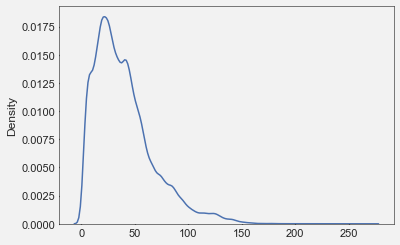

In [115]:
sns.kdeplot(skim_mean_am.unstack())

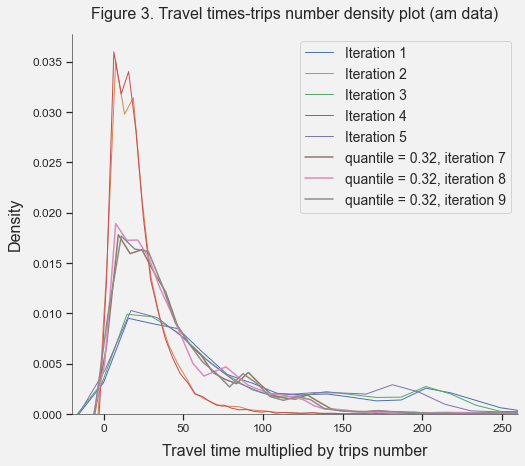

In [116]:
#plot with the first column devided by 3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.facecolor':'#F2F2F2', 'figure.facecolor':'#F2F2F2','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
sns.color_palette("Set3", 10)
for i,color in zip(range(am_multipl_plot.shape[1]),sns.color_palette().as_hex()[0:am_multipl_plot.shape[1]]):
    if i<=4:
        sns.kdeplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1,label="Iteration "+str(i+1),color=color)
        #sns.histplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(am_multipl_plot.iloc[:,i].max()/10), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
    else:
        sns.kdeplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bw_adjust=0.35,linewidth=1.5,label="quantile = 0.32, "+"iteration "+str(i+2),color=color)
        #sns.histplot(am_multipl_plot[am_multipl_plot.iloc[:,i]!=0].iloc[:,i],bins=int(am_multipl_plot.iloc[:,i].max()/10), 
                     #stat="density",alpha=0.2,linewidth=0,color=color)
#sns.kdeplot(qgis_am[qgis_am[1]!=0]["multipl"],bw_adjust=0.35,linewidth=1,label="qgis",color="black")
plt.xlim(-20,260)
plt.legend(fontsize=14)
plt.xlabel("Travel time multiplied by trips number",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.xticks(visible=True,fontsize=12)
plt.yticks(visible=True,fontsize=12)
plt.title("Figure 3. Travel times-trips number density plot (am data)",fontsize=16,pad=15)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Presentation 13.07\density_plot_am.svg")

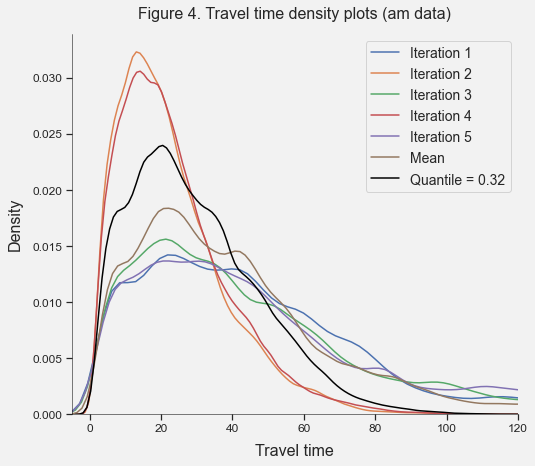

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.facecolor':'#F2F2F2', 'figure.facecolor':'#F2F2F2','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
for i in range(0,travel_times_am.shape[1]):
    sns.kdeplot(travel_times_am.iloc[:,i],label="Iteration "+str(i+1))
sns.kdeplot(skim_mean_am.unstack(),label="Mean")
sns.kdeplot(travel_times_am.quantile(q=0.32,axis=1),label="Quantile = 0.32",color="black")
plt.legend(fontsize=14)
plt.xlim(-5,120)
plt.xlabel("Travel time",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.xticks(visible=True,fontsize=12)
plt.yticks(visible=True,fontsize=12)
plt.title("Travel time density plots (am data)",fontsize=16,pad=15)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Poster\Plots\travel_times_density_plot_am.svg")

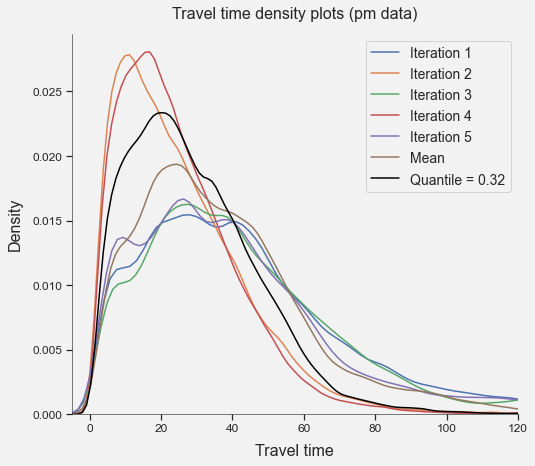

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white',rc={'ytick.left': True,'xtick.bottom': True, 'axes.edgecolor': 'black','axes.facecolor':'#F2F2F2', 'figure.facecolor':'#F2F2F2','axes.linewidth': 0.5})
plt.figure(figsize=(8, 7))
for i in range(0,travel_times_pm.shape[1]):
    sns.kdeplot(travel_times_pm.iloc[:,i],label="Iteration "+str(i+1))
sns.kdeplot(skim_mean_pm.unstack(),label="Mean")
sns.kdeplot(travel_times_pm.quantile(q=0.32,axis=1),label="Quantile = 0.32",color="black")
plt.legend(fontsize=14)
plt.xlim(-5,120)
plt.xlabel("Travel time",fontsize=16,labelpad=10)
plt.ylabel("Density",fontsize=16,labelpad=10)
plt.xticks(visible=True,fontsize=12)
plt.yticks(visible=True,fontsize=12)
plt.title("Travel time density plots (pm data)",fontsize=16,pad=15)
sns.despine()
plt.rcParams['xtick.major.size'] = 0.5
plt.rcParams['ytick.major.size'] = 0.5
plt.savefig(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Poster\Plots\travel_times_density_plot_pm.svg")

(-5.0, 120.0)

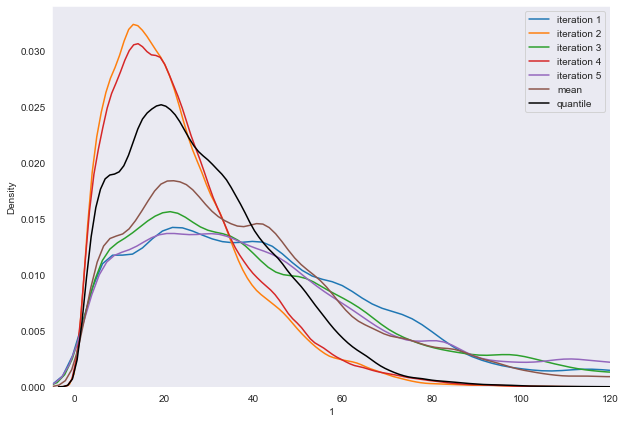

In [127]:
plt.figure(figsize=(10, 7))
for i in range(0,travel_times_am.shape[1]):
    sns.kdeplot(travel_times_am.iloc[:,i],label="iteration "+str(i+1))
sns.kdeplot(skim_mean_am.unstack(),label="mean")
sns.kdeplot(travel_times_am.quantile(q=0.3,axis=1),label="quantile",color="black")
plt.legend()
plt.xlim(-5,120)

(-5.0, 120.0)

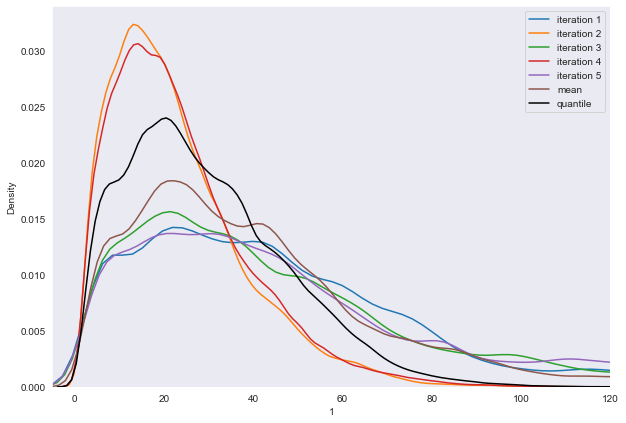

In [128]:
plt.figure(figsize=(10, 7))
for i in range(0,travel_times_am.shape[1]):
    sns.kdeplot(travel_times_am.iloc[:,i],label="iteration "+str(i+1))
sns.kdeplot(skim_mean_am.unstack(),label="mean")
sns.kdeplot(travel_times_am.quantile(q=0.32,axis=1),label="quantile",color="black")
plt.legend()
plt.xlim(-5,120)

(-5.0, 120.0)

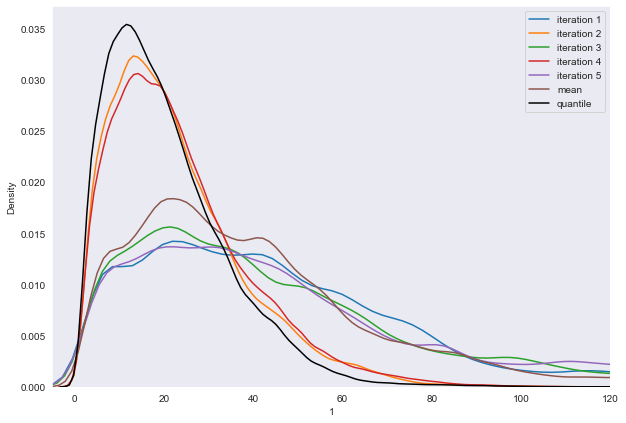

In [129]:
plt.figure(figsize=(10, 7))
for i in range(0,travel_times_am.shape[1]):
    sns.kdeplot(travel_times_am.iloc[:,i],label="iteration "+str(i+1))
sns.kdeplot(skim_mean_am.unstack(),label="mean")
sns.kdeplot(travel_times_am.quantile(q=0,axis=1),label="quantile",color="black")
plt.legend()
plt.xlim(-5,120)

(-5.0, 120.0)

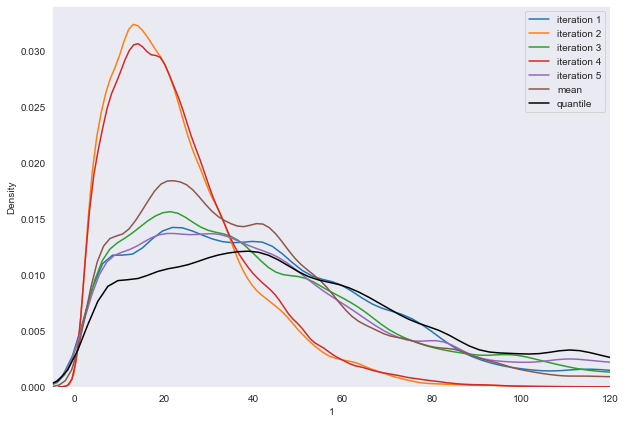

In [130]:
plt.figure(figsize=(10, 7))
for i in range(0,travel_times_am.shape[1]):
    sns.kdeplot(travel_times_am.iloc[:,i],label="iteration "+str(i+1))
sns.kdeplot(skim_mean_am.unstack(),label="mean")
sns.kdeplot(travel_times_am.quantile(q=1,axis=1),label="quantile",color="black")
plt.legend()
plt.xlim(-5,120)

In [132]:
#rows only with nans
skim_am_quantile=travel_times_am.quantile(q=0.32,axis=1).unstack()
#columns
columns_drop=travel_times_am.quantile(q=0.32,axis=1).unstack().isna().sum(axis=0)[travel_times_am.quantile(q=0.32,axis=1).unstack().isna().sum(axis=0)>8].index
#rows
index_drop=travel_times_am.quantile(q=0.32,axis=1).unstack().isna().sum(axis=1)[travel_times_am.quantile(q=0.32,axis=1).unstack().isna().sum(axis=1)>8].index
skim_am_quantile=skim_am_quantile.drop(index=index_drop).drop(columns=columns_drop).fillna(0)
skim_am_quantile.to_csv("skim_am_quantile.csv")

In [107]:
#rows only with nans
skim_am_quantile=travel_times_am.quantile(q=0.37716999228,axis=1).unstack()
#columns
columns_drop=travel_times_am.quantile(q=0.37716999228,axis=1).unstack().isna().sum(axis=0)[travel_times_am.quantile(q=0.37716999228,axis=1).unstack().isna().sum(axis=0)>8].index
#rows
index_drop=travel_times_am.quantile(q=0.37716999228,axis=1).unstack().isna().sum(axis=1)[travel_times_am.quantile(q=0.37716999228,axis=1).unstack().isna().sum(axis=1)>8].index
skim_am_quantile=skim_am_quantile.drop(index=index_drop).drop(columns=columns_drop).fillna(0)
skim_am_quantile.to_csv("skim_am_quantile_optimal.csv")

In [108]:
#rows only with nans
skim_pm_quantile=travel_times_pm.quantile(q=0.379914302902,axis=1).unstack()
#columns
columns_drop=travel_times_pm.quantile(q=0.379914302902,axis=1).unstack().isna().sum(axis=0)[travel_times_pm.quantile(q=0.379914302902,axis=1).unstack().isna().sum(axis=0)>8].index
#rows
index_drop=travel_times_pm.quantile(q=0.379914302902,axis=1).unstack().isna().sum(axis=1)[travel_times_pm.quantile(q=0.379914302902,axis=1).unstack().isna().sum(axis=1)>8].index
skim_pm_quantile=skim_pm_quantile.drop(index=index_drop).drop(columns=columns_drop).fillna(0)
skim_pm_quantile.to_csv("skim_pm_quantile_optimal.csv")

In [ ]:
skim_am_quantile

In [133]:
skim_am_quantile

,1,2,3,4,5,6,7,8,9,10,...,607,608,609,610,611,612,613,614,615,616
1,0.000000,9.279499,6.266541,4.689911,29.701962,32.386187,27.512325,16.450974,11.368527,9.157100,...,62.190384,65.649009,67.712113,62.595899,68.708241,60.007440,66.044172,63.991351,61.721053,67.406197
2,10.852354,0.000000,4.989864,6.907800,26.691688,29.389761,24.504892,13.527023,8.441792,6.249968,...,59.305778,62.764399,64.827503,59.711295,65.760973,57.122836,63.159568,61.106747,58.836449,64.521593
3,7.702088,4.977821,0.000000,3.760425,23.781182,26.479657,21.594386,10.639410,5.559963,4.069731,...,56.445237,59.903853,61.966957,56.850760,62.865156,54.262298,60.299033,58.246212,55.975912,61.661058
4,5.946574,6.585160,3.584854,0.000000,26.926546,29.612668,24.738803,13.773628,8.671877,6.406117,...,59.522338,62.980957,65.044061,59.927856,65.908843,57.339397,63.376128,61.323307,59.053009,64.738153
5,31.839455,27.340801,24.479619,27.909780,0.000000,4.406358,5.174829,17.971633,20.737765,25.357330,...,50.046331,53.504942,55.568047,50.451854,56.415492,47.863392,53.900128,51.847307,49.577005,55.262154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,61.310789,56.871899,53.950504,57.339245,56.427747,59.164772,54.186858,56.602771,59.775336,45.892237,...,4.670284,5.281915,7.341136,3.415273,38.765557,0.000000,6.841699,4.812704,2.527994,8.208430
613,65.199414,60.760525,57.839129,61.227873,60.316372,63.053398,58.075484,60.491397,63.663961,49.780868,...,8.584660,9.025293,11.084513,4.863400,42.682185,4.353089,0.000000,3.226385,4.920994,3.619335
614,67.339398,62.900508,59.979113,63.367854,62.456353,65.193378,60.215464,62.631377,65.803942,51.920849,...,10.722659,11.163293,13.222513,2.706975,44.822707,6.487541,4.386758,0.000000,2.755665,5.753489
615,63.253914,58.815025,55.893629,59.282373,58.370875,61.107901,56.129987,58.545900,61.718464,47.835368,...,6.610186,7.050818,9.110038,4.308587,40.708868,2.379739,3.352929,5.549891,0.000000,1.987916


In [134]:
travel_times_am.quantile(q=0.32,axis=1)

1    2       9.279499
     3       6.266541
     4       4.689911
     5      29.701962
     6      32.386187
              ...    
616  611    41.058183
     612     2.729823
     613     3.371328
     614     5.569077
     615     3.772073
Name: 0.32, Length: 371814, dtype: float64

(-5.0, 120.0)

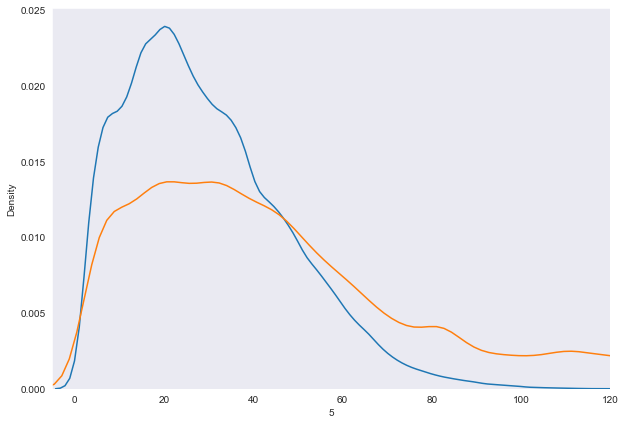

In [135]:
plt.figure(figsize=(10, 7))
sns.kdeplot(skim_am_quantile.unstack())
sns.kdeplot(travel_times_am.iloc[:,4],label="iteration "+str(i+1))
plt.xlim(-5,120)

(-5.0, 120.0)

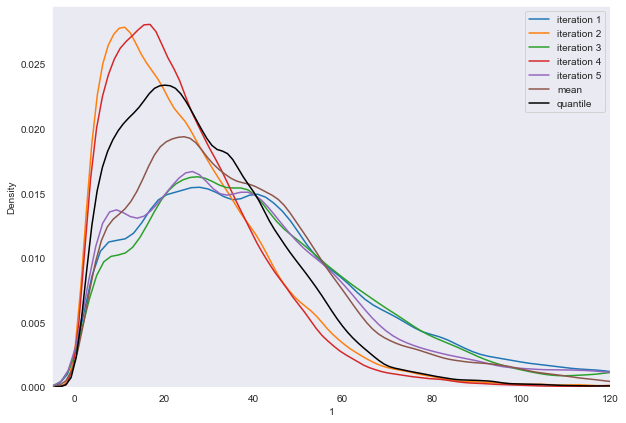

In [136]:
plt.figure(figsize=(10, 7))
for i in range(0,travel_times_pm.shape[1]):
    sns.kdeplot(travel_times_pm.iloc[:,i],label="iteration "+str(i+1))
sns.kdeplot(skim_mean_pm.unstack(),label="mean")
sns.kdeplot(travel_times_pm.quantile(q=0.32,axis=1),label="quantile",color="black")
plt.legend()
plt.xlim(-5,120)

In [138]:
#rows only with nans
skim_pm_quantile=travel_times_pm.quantile(q=0.32,axis=1).unstack()
#columns
columns_drop=travel_times_pm.quantile(q=0.32,axis=1).unstack().isna().sum(axis=0)[travel_times_pm.quantile(q=0.32,axis=1).unstack().isna().sum(axis=0)>8].index
#rows
index_drop=travel_times_pm.quantile(q=0.32,axis=1).unstack().isna().sum(axis=1)[travel_times_pm.quantile(q=0.32,axis=1).unstack().isna().sum(axis=1)>8].index
skim_pm_quantile=skim_pm_quantile.drop(index=index_drop).drop(columns=columns_drop).fillna(0)
skim_pm_quantile.to_csv("skim_pm_quantile.csv")

In [139]:
skim_pm_quantile

,1,2,3,4,5,6,7,8,9,10,...,607,608,609,610,611,612,613,614,615,616
1,0.000000,9.717295,6.942740,9.144041,29.959963,32.499927,27.935220,17.255402,11.886002,9.590460,...,61.946951,64.486900,66.258391,62.135686,71.026611,59.742936,65.726783,63.474379,61.443183,67.227337
2,24.973218,0.000000,5.049806,26.034551,26.657702,29.203449,24.633629,13.967288,8.580223,6.295678,...,58.642566,61.182515,62.954006,58.831301,67.732589,56.438551,62.422397,60.169994,58.138798,63.922951
3,13.921514,6.487071,0.000000,14.190990,23.635583,26.181330,21.611510,10.925977,5.558103,6.394111,...,55.645370,58.185320,59.956811,55.834105,64.753359,53.441356,59.425202,57.172798,55.141602,60.925756
4,5.322982,6.896825,4.114808,0.000000,27.132434,29.678181,25.108361,14.415760,9.054958,6.787973,...,59.183675,61.723622,63.495113,59.372410,68.207250,56.979660,62.963506,60.711103,58.679907,64.464061
5,115.027575,95.652355,89.520783,116.167295,0.000000,4.302601,5.371124,51.797594,59.266171,41.566833,...,52.193629,54.733576,56.505067,52.382366,61.209882,49.989616,55.973462,53.721059,51.689863,57.474016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,152.729934,134.513272,126.293920,153.431411,62.228372,64.768340,60.203637,88.449897,92.913761,56.470528,...,4.547897,4.602334,6.372682,3.219654,35.549144,0.000000,6.794918,4.565146,2.531648,8.308888
613,157.156882,138.940220,130.720860,157.858359,66.535128,69.075099,64.510391,92.917499,97.381375,60.897462,...,8.794345,8.598680,10.364366,4.780177,39.841967,4.584978,0.000000,3.148613,4.964005,3.794804
614,159.410555,141.193893,132.974533,160.112032,68.772687,71.312652,66.747944,95.179491,99.643372,63.151142,...,11.038713,10.862683,12.629068,2.692970,42.078766,6.826332,4.524108,0.000000,2.885957,6.032864
615,154.965981,136.749319,128.529964,155.667458,64.354957,66.894931,62.330223,90.713825,95.177701,58.706580,...,6.614574,6.399780,8.170128,4.108328,37.659478,2.392942,3.292907,5.375181,0.000000,1.941074


In [140]:
travel_times_pm.quantile(q=0.32,axis=1)

1    2       9.717295
     3       6.942740
     4       9.144041
     5      29.959963
     6      32.499927
              ...    
616  611    38.059319
     612     2.780173
     613     3.343893
     614     5.464617
     615     3.810778
Name: 0.32, Length: 371678, dtype: float64

# create algorithm to get skim matrix with specific quantile value

In [145]:
def skim_quantile(travel_times, q, time):
    skim_quantile=travel_times.quantile(q=q,axis=1).unstack()
    columns_drop=travel_times.quantile(q=q,axis=1).unstack().isna().sum(axis=0)[travel_times.quantile(q=q,axis=1).unstack().isna().sum(axis=0)>8].index
    index_drop=travel_times.quantile(q=q,axis=1).unstack().isna().sum(axis=1)[travel_times.quantile(q=q,axis=1).unstack().isna().sum(axis=1)>8].index
    skim_quantile=skim_quantile.drop(index=index_drop).drop(columns=columns_drop).fillna(0)
    skim_quantile.to_csv("skim_quantile_"+time+"_"+str(q)+".csv")

In [146]:
for q in [0,0.2,0.4,0.6,0.8,1]:
    skim_quantile(travel_times_am,q,"am")

In [147]:
for q in [0,0.2,0.4,0.6,0.8,1]:
    skim_quantile(travel_times_pm,q,"pm")

24625
24986


(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

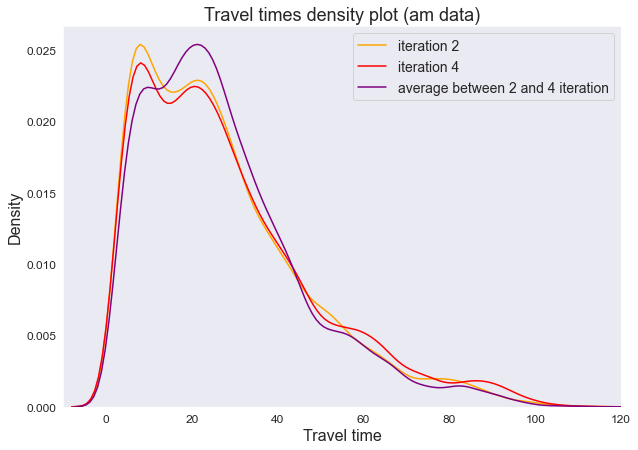

In [89]:
plt.figure(figsize=(10, 7))
sns.color_palette("Set3", 10)
for i,color in zip([1,3],["orange","red"]):
    sns.kdeplot(travel_times_am.iloc[:,i].drop(index=trips_number_am[trips_number_am.iloc[:,i]==0].index),label="iteration "+str(i+1),color=color)
    print(len(travel_times_am.iloc[:,i].drop(index=trips_number_am[trips_number_am.iloc[:,i]==0].index)))
sns.kdeplot((travel_times_am.iloc[:,1].drop(index=trips_number_am[trips_number_am.iloc[:,1]==0].index)+travel_times_am.iloc[:,3].drop(index=trips_number_am[trips_number_am.iloc[:,3]==0].index))/2,label="average between 2 and 4 iteration",color="purple")
plt.xlim(-10,120)
plt.legend(fontsize=14)
plt.title("Travel times density plot (am data)",fontsize=18)
plt.xlabel("Travel time",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

<AxesSubplot:xlabel='4', ylabel='Density'>

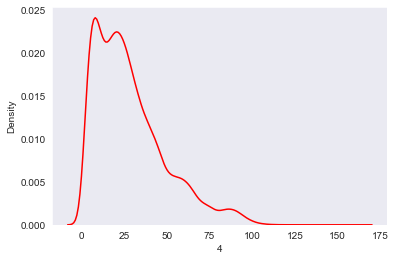

In [90]:
sns.kdeplot(travel_times_am.iloc[:,i].drop(index=trips_number_am[trips_number_am.iloc[:,i]==0].index),label="iteration "+str(i+1),color=color)

In [91]:
(travel_times_am.iloc[:,1].drop(index=trips_number_am[trips_number_am.iloc[:,1]==0].index)+travel_times_am.iloc[:,3].drop(index=trips_number_am[trips_number_am.iloc[:,3]==0].index))/2

1    3           NaN
     10          NaN
     14          NaN
     62          NaN
     146         NaN
              ...   
616  585         NaN
     592         NaN
     593    6.288508
     594    4.593153
     606         NaN
Length: 33674, dtype: float64

In [92]:
travel_times_am.iloc[:,1].drop(index=trips_number_am[trips_number_am.iloc[:,1]==0].index)

1    3       6.382531
     14     16.750872
     146    54.792805
     183    46.872112
     205    58.747925
              ...    
616  582     5.075848
     585     7.893100
     592    22.443293
     593     6.214279
     594     4.579319
Name: 2, Length: 24625, dtype: float64

In [93]:
travel_times_am.iloc[:,3].drop(index=trips_number_am[trips_number_am.iloc[:,3]==0].index)

1    10      9.112892
     62     43.006550
     205    55.915821
     234    53.751740
     255    47.583370
              ...    
616  580    19.565092
     582     4.957264
     593     6.362737
     594     4.606987
     606     8.296844
Name: 4, Length: 24986, dtype: float64

In [94]:
(6.214279+6.362737)/2

6.288508

<h1>Correlation matrixes</h1>

In [120]:
am_multipl.corr(method='spearman').to_excel(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Meeting 04.07\am_corr_matrix.xlsx")
am_multipl.corr(method='spearman')

,1,2,3,4
1,1.000000,0.485064,0.625105,0.534154
2,0.485064,1.000000,0.560355,0.623507
3,0.625105,0.560355,1.000000,0.584283
4,0.534154,0.623507,0.584283,1.000000


In [121]:
pm_multipl.corr(method='spearman').to_excel(r"C:\Users\anash\OneDrive - Tartu Ülikool\Aalto internship\Meeting 04.07\pm_corr_matrix.xlsx")
pm_multipl.corr(method='spearman')

,1,2,3,4
1,1.000000,0.366799,0.458685,0.394365
2,0.366799,1.000000,0.457488,0.509850
3,0.458685,0.457488,1.000000,0.467675
4,0.394365,0.509850,0.467675,1.000000


<h1>Statistical tests</h1>

In [122]:
#check whether the data is normally distributed
from scipy.stats import norm
from scipy.stats import shapiro
for i in range(am_multipl.shape[1]):
    print(shapiro(am_multipl.iloc[:,i].dropna()))

ShapiroResult(statistic=0.18642067909240723, pvalue=0.0)
ShapiroResult(statistic=0.16125011444091797, pvalue=0.0)
ShapiroResult(statistic=0.1688152551651001, pvalue=0.0)
ShapiroResult(statistic=0.17917561531066895, pvalue=0.0)


C:\Users\anash\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [123]:
for i in range(pm_multipl.shape[1]):
    print(shapiro(pm_multipl.iloc[:,i].dropna()))

ShapiroResult(statistic=0.1497860550880432, pvalue=0.0)
ShapiroResult(statistic=0.1352243423461914, pvalue=0.0)
ShapiroResult(statistic=0.14445281028747559, pvalue=0.0)
ShapiroResult(statistic=0.13948404788970947, pvalue=0.0)


In [124]:
#the data is not normally distributed, we may use Wilcoxon rank sum test

In [125]:
from scipy.stats import ranksums
for i in range(0,am_multipl.shape[1]-1):
    print(ranksums(am_multipl.iloc[:,i].dropna(),am_multipl.iloc[:,i+1].dropna()))

RanksumsResult(statistic=15.306476517589791, pvalue=6.92132489876471e-53)
RanksumsResult(statistic=-13.641433051558787, pvalue=2.2705442539438036e-42)
RanksumsResult(statistic=12.77540033810813, pvalue=2.249870827464077e-37)


In [126]:
from scipy.stats import ranksums
for i in range(0,pm_multipl.shape[1]-1):
    print(ranksums(pm_multipl.iloc[:,i].dropna(),pm_multipl.iloc[:,i+1].dropna()))

RanksumsResult(statistic=11.913003858688322, pvalue=1.0126233738023137e-32)
RanksumsResult(statistic=-11.491444416525649, pvalue=1.4565590417626817e-30)
RanksumsResult(statistic=11.203979275843261, pvalue=3.8982120637236606e-29)


In [240]:
#statistical test tells us that two sets of measurements (iterations #1-2) are not drawn from the same distribution, but
#iterations #2-3 are from the same distribution (p>0.05)